In [1]:
#PREPROCESSING IMPORT
import re
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#IMPLEMENTATION IMPORT
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as ply
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier
%matplotlib inline

In [2]:
#load dataset
training = pd.read_csv('train-top100.csv', sep = ',')
dev = pd.read_csv('dev-top100.csv', sep = ',')
test = pd.read_csv('test-top100.csv', sep = ',')

# Preprocessing

In [ ]:
#view raw training data
training.head()

In [ ]:
#check if there are any null values exist
training.info()
training.isnull().sum()
#conclusion: no null values in the dataset

In [33]:
#preprocessing data
print(training['Location'].unique())
#make nominal attributes to numerica attributes
label_location = LabelEncoder()
training['Location'] = label_location.fit_transform(training['Location'])
test['Location'] = label_location.fit_transform(test['Location'])
#data.head()

[1 0 2 3]


In [ ]:
#observe distribution of class labels in data
sns.countplot(training['Location'])
ply.title("Distribution of Training Location Labels", fontdict=None, loc='center')
#conclusion: all locations are equally prevalent in the data
sns.countplot(dev['Location'])
ply.title("Distribution of Development Location Labels", fontdict=None, loc='center')

In [3]:
#PREPROCESSING DATA
def process(df):
    for feature in list(df.columns.values):
        count = 0
        #convert text to lowercase
        feature = feature.lower()
        #remove numbers 
        feature = re.sub(r'\d+','', feature)
        #remove punctuation
        feature = re.sub(r'[^\w\s]','',feature)
        #remove white spaces
        feature = feature.strip()

        #remove stop words
        if feature in ENGLISH_STOP_WORDS:
            df = df.drop(feature, 1)

        #stemming - reduce words to their stem
        #lemmatisation - get rid of inflections

        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()

        feature = stemmer.stem(feature)
        feature = lemmatizer.lemmatize(feature)

        #delete duplicated feature headers
        if feature in list(df.columns.values):
            count = 1
        if count >1:
            df = df[feature].duplicated(Keep = False)
        return df

# Training and test dataset

In [4]:
#TRAINING
#Separate dataset as response variable and feature variable
training = process(training)
one_hot = pd.get_dummies(training['Location'])

X_train = training.drop('Location', axis = 1)
y_train = training['Location']

In [5]:
#TEST
test = process(test)
X_test = test.drop('Location', axis = 1)

In [5]:
#DEVELOPMENT
dev = process(dev)
X_test = dev.drop('Location', axis = 1)
y_test = dev['Location']


In [6]:
#Scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
#cut down for faster processing - not ideal approach
X_test = X_test[0:2000]
y_test = y_test[0:2000]
X_train = X_train[0:2000]
y_train = y_train[0:2000]

# Learning Classifier Behaviours

<b>SVM Classifier</b>

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)

In [ ]:
#calculate model performance
svm_acc = accuracy_score(y_test, pred_clf)
svm_f = f1_score(y_test, pred_clf, average='macro')

#print model summary
print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

print(svm_acc)

<b> Naive Bayes Classifier </b>

In [36]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

In [8]:
#write predictions to csvfile
inputdata = pd.DataFrame(list(pred_nb),list(test['Instance_ID']))
inputdata.to_csv('GaussianNB_predictions.csv') 

In [37]:
#calculate model performance
nb_acc = accuracy_score(y_test, pred_nb)
nb_f = f1_score(y_test, pred_nb, average='macro')

#print model summary
print(classification_report(y_test, pred_nb))
print(confusion_matrix(y_test, pred_nb))
print(nb_acc)

             precision    recall  f1-score   support

   Brisbane       0.27      0.26      0.26       500
  Melbourne       0.27      0.27      0.27       505
      Perth       0.27      0.29      0.28       486
     Sydney       0.28      0.27      0.28       509

avg / total       0.27      0.27      0.27      2000

[[129 130 122 119]
 [109 135 141 120]
 [124 108 143 111]
 [120 134 116 139]]
0.273


<b> Multinomial Naive Bayes Classifier </b>

In [38]:
nb_multi = MultinomialNB()
nb_multi.fit(X_train, y_train)
pred_nb_multi = nb_multi.predict(X_test)

ValueError: Input X must be non-negative

In [10]:
#write predictions to csvfile
inputdata = pd.DataFrame(list(pred_nb_multi),list(test['Instance_ID']))
inputdata.to_csv('MultinomialNB_predictions.csv') 

In [ ]:
#calculate model performance
nb_multi_acc = accuracy_score(y_test, pred_nb_multi)
multi_f = f1_score(y_test, pred_nb_multi, average='macro')

#print model summary
print(classification_report(y_test,pred_nb_multi))
print(nb_multi_acc)

labels = np.unique(pred_nb_multi)
cm = confusion_matrix(y_test, pred_nb_multi,labels)
ax= ply.subplot()
sns.heatmap(cm, ax = ax, cmap="YlGnBu")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Multinomial NB Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels);



<b> One-R Baseline Classifier</b>

In [ ]:
#fit one-r model
one_r = DecisionTreeClassifier(max_depth=1)
one_r.fit(X_train, y_train)
pred_one_r = one_r.predict(X_test)

In [ ]:
#calculate model performance
one_r_acc = accuracy_score(y_test, pred_one_r)
one_r_f = f1_score(y_test, pred_one_r, average='macro')

#print model summary
print(classification_report(y_test,pred_one_r))
print(confusion_matrix(y_test,pred_one_r))

# Classifier Combinations

<b> Stacking </b>

In [ ]:
#apply ensemble method using multinomial NB to break ties
clf1 = KNeighborsClassifier(n_neighbors=20)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
multi = MultinomialNB()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=multi)

sclf.fit(X_train, y_train)
pred_sclf = sclf.predict(X_test)
#sclf_acc = accuracy_score(y_test, pred_sclf)
#sclf_f = f1_score(y_test, pred_sclf, average = 'macro')

#print('3-fold cross validation:\n')

#for clf, label in zip([clf1, clf2, clf3, sclf], 
 #                     ['KNN', 
 #                      'Random Forest', 
 #                      'Naive Bayes',
 #                      'StackingClassifier']):

#    scores = model_selection.cross_val_score(clf, X_test, y_test, 
#                                              cv=3, scoring='accuracy')
#    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
#         % (scores.mean(), scores.std(), label))

In [ ]:
#extracted from Prac 10 COMP300027 Solutions
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


np.random.seed(1)
class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        #print(yhats.shape)
        assert yhats.shape[0] == X.shape[0]
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)
    


classifiers = [LogisticRegression(),
                KNeighborsClassifier(),
                GaussianNB(),
                MultinomialNB(),
                DecisionTreeClassifier()]

meta_classifier = DecisionTreeClassifier()
stacker = StackingClassifier(classifiers, meta_classifier)

stacker.fit(X_train, y_train)
print('stacker acc:', stacker.score(X_test, y_test))

<b>Random Forest Classifier</b>

In [40]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=350, max_features='sqrt')
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

In [14]:
#Tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=1000, max_features=auto, max_depth=140 .............
[CV] n_estimators=1000, max_features=auto, max_depth=140 .............
[CV] n_estimators=1000, max_features=auto, max_depth=140 .............
[CV] n_estimators=1400, max_features=auto, max_depth=100 .............
[CV]  n_estimators=1000, max_features=auto, max_depth=140, total=   7.4s
[CV] n_estimators=1400, max_features=auto, max_depth=100 .............
[CV]  n_estimators=1000, max_features=auto, max_depth=140, total=   7.7s
[CV] n_estimators=1400, max_features=auto, max_depth=100 .............
[CV]  n_estimators=1000, max_features=auto, max_depth=140, total=   7.9s
[CV] n_estimators=800, max_features=sqrt, max_depth=260 ..............
[CV]  n_estimators=1400, max_features=auto, max_depth=100, total=  10.5s
[CV] n_estimators=800, max_features=sqrt, max_depth=260 ..............
[CV]  n_estimators=800, max_features=sqrt, max_depth=260, total=   6.3s
[CV] 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min


[CV]  n_estimators=1400, max_features=auto, max_depth=500, total=  11.6s
[CV] n_estimators=1000, max_features=sqrt, max_depth=300 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=300, total=   7.7s
[CV] n_estimators=1000, max_features=sqrt, max_depth=300 .............
[CV]  n_estimators=1400, max_features=auto, max_depth=500, total=  10.4s
[CV] n_estimators=1800, max_features=auto, max_depth=420 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=300, total=   7.5s
[CV] n_estimators=1800, max_features=auto, max_depth=420 .............
[CV]  n_estimators=1400, max_features=auto, max_depth=500, total=  11.2s
[CV] n_estimators=1800, max_features=auto, max_depth=420 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=300, total=   9.9s
[CV] n_estimators=800, max_features=sqrt, max_depth=300 ..............
[CV]  n_estimators=800, max_features=sqrt, max_depth=300, total=   7.8s
[CV] n_estimators=800, max_features=sqrt, max_depth=300 ........

[CV]  n_estimators=1400, max_features=sqrt, max_depth=260, total=  12.0s
[CV] n_estimators=1800, max_features=auto, max_depth=None ............
[CV]  n_estimators=1400, max_features=sqrt, max_depth=260, total=  11.7s
[CV] n_estimators=1800, max_features=auto, max_depth=None ............
[CV]  n_estimators=1400, max_features=sqrt, max_depth=260, total=  12.5s
[CV] n_estimators=1200, max_features=auto, max_depth=140 .............
[CV]  n_estimators=1800, max_features=auto, max_depth=None, total=  17.1s
[CV] n_estimators=1200, max_features=auto, max_depth=140 .............
[CV]  n_estimators=1200, max_features=auto, max_depth=140, total=  11.7s
[CV] n_estimators=1200, max_features=auto, max_depth=140 .............
[CV]  n_estimators=1800, max_features=auto, max_depth=None, total=  17.2s
[CV] n_estimators=600, max_features=auto, max_depth=460 ..............
[CV]  n_estimators=1800, max_features=auto, max_depth=None, total=  17.2s
[CV] n_estimators=600, max_features=auto, max_depth=460 ....

[CV]  n_estimators=200, max_features=auto, max_depth=220, total=   1.7s
[CV] n_estimators=1000, max_features=auto, max_depth=500 .............
[CV]  n_estimators=1000, max_features=auto, max_depth=500, total=   9.2s
[CV] n_estimators=1000, max_features=auto, max_depth=500 .............
[CV]  n_estimators=1000, max_features=auto, max_depth=500, total=   9.0s
[CV] n_estimators=1400, max_features=auto, max_depth=460 .............
[CV]  n_estimators=2000, max_features=sqrt, max_depth=340, total=  17.9s
[CV] n_estimators=1400, max_features=auto, max_depth=460 .............
[CV]  n_estimators=2000, max_features=sqrt, max_depth=340, total=  18.7s
[CV] n_estimators=1400, max_features=auto, max_depth=460 .............
[CV]  n_estimators=1000, max_features=auto, max_depth=500, total=   9.8s
[CV] n_estimators=1600, max_features=auto, max_depth=500 .............
[CV]  n_estimators=1400, max_features=auto, max_depth=460, total=  14.1s
[CV] n_estimators=1600, max_features=auto, max_depth=500 .......

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.0min


[CV]  n_estimators=1400, max_features=auto, max_depth=460, total=  13.3s
[CV] n_estimators=1600, max_features=auto, max_depth=500 .............
[CV]  n_estimators=1400, max_features=auto, max_depth=460, total=  14.8s
[CV] n_estimators=800, max_features=sqrt, max_depth=460 ..............
[CV]  n_estimators=1600, max_features=auto, max_depth=500, total=  17.8s
[CV] n_estimators=800, max_features=sqrt, max_depth=460 ..............
[CV]  n_estimators=800, max_features=sqrt, max_depth=460, total=   8.0s
[CV] n_estimators=800, max_features=sqrt, max_depth=460 ..............
[CV]  n_estimators=1600, max_features=auto, max_depth=500, total=  16.5s
[CV] n_estimators=1000, max_features=auto, max_depth=None ............
[CV]  n_estimators=1600, max_features=auto, max_depth=500, total=  16.4s
[CV] n_estimators=1000, max_features=auto, max_depth=None ............
[CV]  n_estimators=800, max_features=sqrt, max_depth=460, total=   6.6s
[CV] n_estimators=1000, max_features=auto, max_depth=None .......

[CV]  n_estimators=1600, max_features=sqrt, max_depth=420, total=  19.7s
[CV] n_estimators=400, max_features=sqrt, max_depth=300 ..............
[CV]  n_estimators=400, max_features=sqrt, max_depth=300, total=   4.6s
[CV] n_estimators=2000, max_features=auto, max_depth=140 .............
[CV]  n_estimators=1600, max_features=sqrt, max_depth=420, total=  18.9s
[CV] n_estimators=2000, max_features=auto, max_depth=140 .............
[CV]  n_estimators=400, max_features=sqrt, max_depth=300, total=   4.3s
[CV] n_estimators=2000, max_features=auto, max_depth=140 .............
[CV]  n_estimators=1600, max_features=sqrt, max_depth=420, total=  19.1s
[CV] n_estimators=1000, max_features=auto, max_depth=340 .............
[CV]  n_estimators=1000, max_features=auto, max_depth=340, total=  10.4s
[CV] n_estimators=1000, max_features=auto, max_depth=340 .............
[CV]  n_estimators=2000, max_features=auto, max_depth=140, total=  20.9s
[CV] n_estimators=1000, max_features=auto, max_depth=340 ........

[CV] n_estimators=800, max_features=auto, max_depth=None .............
[CV]  n_estimators=1800, max_features=auto, max_depth=140, total=  14.5s
[CV] n_estimators=1800, max_features=auto, max_depth=380 .............
[CV]  n_estimators=800, max_features=auto, max_depth=None, total=   6.9s
[CV] n_estimators=1800, max_features=auto, max_depth=380 .............
[CV]  n_estimators=800, max_features=auto, max_depth=None, total=   6.5s
[CV] n_estimators=1800, max_features=auto, max_depth=380 .............
[CV]  n_estimators=800, max_features=auto, max_depth=None, total=   6.5s
[CV] n_estimators=400, max_features=auto, max_depth=420 ..............
[CV]  n_estimators=400, max_features=auto, max_depth=420, total=   3.4s
[CV] n_estimators=400, max_features=auto, max_depth=420 ..............
[CV]  n_estimators=400, max_features=auto, max_depth=420, total=   3.2s
[CV] n_estimators=400, max_features=auto, max_depth=420 ..............
[CV]  n_estimators=400, max_features=auto, max_depth=420, total=   

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.6min finished


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 380}


In [41]:
#write predictions to csvfile
inputdata = pd.DataFrame(list(pred_rfc),list(test['Instance_ID']))
inputdata.to_csv('RFC_predictions.csv') 

ValueError: Shape of passed values is (1, 2000), indices imply (1, 108148)

             precision    recall  f1-score   support

   Brisbane       0.21      0.21      0.21       500
  Melbourne       0.25      0.26      0.25       505
      Perth       0.23      0.23      0.23       486
     Sydney       0.26      0.26      0.26       509

avg / total       0.24      0.24      0.24      2000

0.239


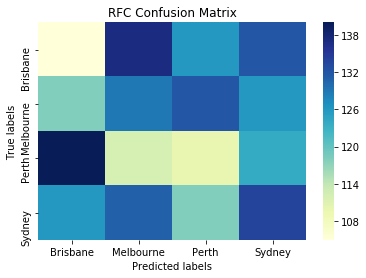

In [25]:
#calculate model performance
rfc_acc = accuracy_score(y_test, pred_rfc)
rfc_f = f1_score(y_test, pred_rfc, average='macro')

#print model summary
print(classification_report(y_test, pred_rfc))
print(rfc_acc)

labels = np.unique(pred_rfc)
cm = confusion_matrix(y_test, pred_rfc,labels)
ax= ply.subplot()
sns.heatmap(cm, ax = ax, cmap="YlGnBu")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('RFC Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels);



<b>Bagging</b>

In [ ]:
bagging = BaggingClassifier(n_estimators = 100)
bagging.fit(X_train, y_train)
pred_bag = bagging.predict(X_test)

In [ ]:
#write predictions to csvfile
inputdata = pd.DataFrame(list(pred_bag),list(dev['Instance_ID']))
inputdata.to_csv('Bagging_predictions.csv') 

In [ ]:
#calculate model performance
bag_acc = accuracy_score(y_test, pred_bag)
bag_f = f1_score(y_test, pred_bag, average='macro')

#print model summary
print(classification_report(y_test, pred_bag))
print(confusion_matrix(y_test, pred_bag))

print(bag_acc)

# Evaluation

In [ ]:
#create graph of accuracy and precision
total_acc = (one_r_acc,nb_multi_acc, nb_acc, svm_acc,rfc_acc,bag_acc, sclf_acc)
total_precision = (one_r_f,multi_f,nb_f,svm_f,rfc_f,bag_f, sclf_f)
titles = ["1-R","Multinomial \n NB","     Gaussian \n NB","SVM", "Random\n Forest Classifier","Bagging", "Stacking"]

N = 7
ind = np.arange(N) 
width = 0.3

#plot graph 
ply.bar(ind, total_acc, width, label='Accuracy')
ply.bar(ind + width, total_precision, width,label='F1 Score')

ply.xticks(ind+0.1, titles)
ply.title("Evaluation Metrics")
ply.xlabel("Classifier Types")
ply.ylabel("Percentage Score")
ply.legend(loc = 5)

In [ ]:
#create error rate graph
total_err = []
for accuracy in total_acc:
    total_err.append(1-accuracy)
    
ply.bar(ind, total_err, width, label='Error Rate')
ply.xticks(ind, titles)
ply.title("Error Rate")
ply.xlabel("Classifier Types")
ply.ylabel("Percentage")

In [ ]:
#view feature selection
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

ply.title("Feature Selection")
ply.ylabel("Token Words")
ply.xlabel("Score")
ply.show()

In [ ]:
#write predictions to csvfile
inputdata = pd.DataFrame(list(pred_clf),list(test['Instance_ID']))
inputdata.to_csv('kaggle.csv') 